<a href="https://colab.research.google.com/github/ilanamultak/siads_699_heart_disease/blob/main/Predicting_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries & Setup

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix


In [2]:
# Clone github repo
!git clone https://github.com/ilanamultak/siads_699_heart_disease.git

# Change the working directory to the cloned repository
os.chdir('/content/siads_699_heart_disease')

# Verify the current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

Cloning into 'siads_699_heart_disease'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 52 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 451.27 KiB | 7.16 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Current working directory: /content/siads_699_heart_disease


In [3]:
# Set Random Seed

RANDOM_SEED = 1738

# Data Descriptions

In [4]:
# Print data descriptions
with open('data/heart-disease.names', 'r') as file:
  content = file.read()

print(content)

Publication Request: 
   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
   This file describes the contents of the heart-disease directory.

   This directory contains 4 databases concerning heart disease diagnosis.
   All attributes are numeric-valued.  The data was collected from the
   four following locations:

     1. Cleveland Clinic Foundation (cleveland.data)
     2. Hungarian Institute of Cardiology, Budapest (hungarian.data)
     3. V.A. Medical Center, Long Beach, CA (long-beach-va.data)
     4. University Hospital, Zurich, Switzerland (switzerland.data)

   Each database has the same instance format.  While the databases have 76
   raw attributes, only 14 of them are actually used.  Thus I've taken the
   liberty of making 2 copies of each database: one with all the attributes
   and 1 with the 14 attributes actually used in past experiments.

   The authors of the databases have requested:

      ...that any publications resulting from the use of th

# Data Cleaning

We can only combine the raw data from Switzerland, Hungary, and Long Beach sources because the Cleveland data file was corrupted (documentation around why can be found in the "heart_disease/WARNING" file)

In [5]:
raw_columns = [
  "id", "ccf", "age", "sex", "painloc", "painexer", "relrest", "pncaden", "cp",
  "trestbps", "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist",
  "restecg", "ekgmo", "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic",
  "proto", "thaldur", "thaltime", "met", "thalach", "thalrest", "tpeakbps",
  "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak", "slope",
  "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref",
  "exerwm", "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num",
  "lmt", "ladprox", "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox",
  "rcadist", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "name", "data_source"
]

data_sources = {"hungary":"data/hungarian.data","switzerland":"data/switzerland.data","long_beach":"data/long-beach-va.data"}

In [6]:
# Consolidate raw data from the 3 sources into one dataframe
df = pd.DataFrame(columns=raw_columns)

for data_source_name, data_source_path in data_sources.items():
  file_path = data_source_path
  with open(file_path, 'r') as file:
    text = file.read().split()

  temp_df = pd.DataFrame(columns=raw_columns)
  row = []
  for val in text:
    if val.isalpha():
      row.append(val)
      row.append(data_source_name)
      temp_df.loc[len(temp_df)] = row
      row = []
    else:
      row.append(val)
  df = pd.concat([df, temp_df], axis=0)

df[raw_columns[:-2]] = df[raw_columns[:-2]].astype(float)
df = df.replace(-9.0,np.nan)
df.head()

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,...,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,name,data_source
0,1254.0,0.0,40.0,1.0,1.0,0.0,0.0,NaN,2.0,140.0,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,name,hungary
1,1255.0,0.0,49.0,0.0,1.0,0.0,0.0,NaN,3.0,160.0,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,name,hungary
2,1256.0,0.0,37.0,1.0,1.0,0.0,0.0,NaN,2.0,130.0,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,name,hungary
3,1257.0,0.0,48.0,0.0,1.0,1.0,1.0,NaN,4.0,138.0,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,name,hungary
4,1258.0,0.0,54.0,1.0,1.0,0.0,1.0,NaN,3.0,150.0,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,name,hungary


In [7]:
pd.set_option('display.max_columns', None)
df.describe()

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restckm,exerckm,restef,restwm,exeref,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,num,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk
count,617.000000,617.0,617.000000,617.000000,617.000000,617.000000,613.000000,0.0,617.000000,558.000000,583.000000,587.000000,230.000000,202.000000,190.000000,527.000000,72.000000,195.000000,615.000000,564.000000,563.000000,564.000000,551.000000,553.000000,554.000000,556.000000,537.000000,505.000000,561.000000,233.000000,512.000000,562.000000,561.000000,554.000000,554.000000,558.000000,558.000000,562.000000,559.000000,555.000000,309.000000,474.000000,475.000000,11.000000,0.0,1.0,28.000000,30.000000,2.000000,5.000000,142.000000,130.000000,44.000000,1.0,606.000000,608.000000,608.000000,617.000000,342.000000,381.000000,371.000000,341.000000,382.000000,332.000000,346.000000,327.000000,372.000000,347.000000,598.000000,598.000000,598.000000,598.000000,601.000000,311.000000,119.000000
mean,1325.489465,0.0,53.055105,0.842788,0.920583,0.593193,0.672104,NaN,3.294976,132.372760,0.408233,174.579216,0.517391,22.133663,23.952632,0.176471,0.944444,0.482051,0.414634,5.758865,15.628774,84.934397,0.036298,0.256781,0.276173,0.208633,0.111732,57.229703,8.775223,6.428755,20.189648,131.042705,75.673797,173.465704,91.644404,132.372760,82.804659,0.423488,0.028623,0.790991,1.932039,14.398734,14.145263,1.545455,NaN,0.0,0.531071,1.033333,0.550000,0.200000,5.690141,1.284615,0.295455,0.0,5.993399,16.286184,84.550987,1.230146,1.555556,1.464567,1.280323,1.202346,1.400524,1.114458,1.187861,1.067278,1.470430,1.207493,1.030100,1.048495,1.132107,1.705686,1.194676,27.623119,5.869748
std,1294.916561,0.0,9.582869,0.364296,0.270607,0.491637,0.469830,NaN,0.913743,19.828097,0.491929,124.349962,0.500787,16.146930,16.428871,0.381582,0.230669,0.500964,0.611066,3.306489,8.804259,1.123440,0.187200,1.013976,0.447508,0.406697,0.315330,52.784478,4.206623,4.299778,37.762087,25.151341,15.183479,26.601875,13.464101,19.828097,10.558013,0.494551,0.166893,1.041776,0.585465,5.702942,5.697171,2.621589,NaN,NaN,0.146195,1.066200,0.070711,0.447214,1.795120,0.958314,0.461522,NaN,3.336246,8.866408,5.140596,1.263447,8.706091,0.499399,0.449764,0.402339,0.490647,0.318847,0.391167,0.250887,0.499797,0.406097,0.336148,0.503910,0.673205,1.834072,0.541946,31.675295,1.650914
min,1.000000,0.0,28.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,81.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,60.000000,37.000000,100.000000,11.000000,0.000000,0.000000,0.000000,0.000000,-2.600000,0.000000,2.000000,2.000000,0.000000,NaN,0.0,0.220000,0.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.220000,3.300000
25%,157.000000,0.0,47.000000,1.000000,1.000000,0.000000,0.000000,NaN,3.000000,120.000000,0.000000,0.000000,0.000000,15.000000,8.500000,0.000000,1.000000,0.000000,0.000000,3.000000,8.000000,84.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,6.000000,3.500000,5.000000,114.250000,65.000000,158.000000,80.000000,120.000000,80.000000,0.000000,0.000000,0.000000,2.000000,10.000000,10.000000,0.000000,NaN,0.0,0.407500,0.000000,0.525000,0.000000,4.250000,0.000000,0.000000,0.0,3.000000,9.000000,84.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.685000,4.800000
50%,1120.000000,0.0,54.000000,1.000000,1.000000,1.000000,1.

In [8]:
# What percentage of values in each column are NULL?
pd.set_option('display.max_rows', None)
df.isnull().sum()/len(df)

,0
id,0.000000
ccf,0.000000
age,0.000000
sex,0.000000
painloc,0.000000
painexer,0.000000
relrest,0.006483
pncaden,1.000000
cp,0.000000
trestbps,0.095624


In [9]:
# Initial selection of features for model
# Starting off with features that are present in >80% of rows and realistically make sense to include
cols_to_keep = [
    "age","sex","painloc","painexer","relrest","cp","trestbps","htn","chol","fbs","restecg",
    "dig","prop","nitr","pro","diuretic","thaldur","met","thalach","thalrest","tpeakbps",
    "tpeakbpd","trestbpd","exang","xhypo","oldpeak","num"
]

old_df = df.copy()
df = df[cols_to_keep].dropna().reset_index(drop=True)
cols_to_rename = {'num':'heart_disease'}
df.rename(columns=cols_to_rename, inplace=True)

# Make heart_disease column binary - either they have heart disease (1) or they don't (0)
df.loc[df['heart_disease'] > 0, 'heart_disease'] = 1

# Create dummy variables for chest pain categories
df.loc[df['cp'] == 1, 'cp_angina_typ'] = 1
df['cp_angina_typ'] = df['cp_angina_typ'].fillna(0)
df.loc[df['cp'] == 2, 'cp_angina_atyp'] = 1
df['cp_angina_atyp'] = df['cp_angina_atyp'].fillna(0)
df.loc[df['cp'] == 3, 'cp_non_anginal'] = 1
df['cp_non_anginal'] = df['cp_non_anginal'].fillna(0)
df.loc[df['cp'] == 4, 'cp_asymptomatic'] = 1
df['cp_asymptomatic'] = df['cp_asymptomatic'].fillna(0)
df.drop('cp', axis=1, inplace=True)

# Create dummy variables for resting ECG categories
df.loc[df['restecg'] == 0, 'restecg_normal'] = 1
df['restecg_normal'] = df['restecg_normal'].fillna(0)
df.loc[df['restecg'] == 1, 'restecg_stt_wave'] = 1
df['restecg_stt_wave'] = df['restecg_stt_wave'].fillna(0)
df.loc[df['restecg'] == 2, 'restecg_lvh'] = 1
df['restecg_lvh'] = df['restecg_lvh'].fillna(0)
df.drop('restecg', axis=1, inplace=True)

df.head()

,age,sex,painloc,painexer,relrest,trestbps,htn,chol,fbs,dig,prop,nitr,pro,diuretic,thaldur,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,heart_disease,cp_angina_typ,cp_angina_atyp,cp_non_anginal,cp_asymptomatic,restecg_normal,restecg_stt_wave,restecg_lvh
0,40.0,1.0,1.0,0.0,0.0,140.0,0.0,289.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,7.0,172.0,86.0,200.0,110.0,86.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,49.0,0.0,1.0,0.0,0.0,160.0,1.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,7.0,156.0,100.0,220.0,106.0,90.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,37.0,1.0,1.0,0.0,0.0,130.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,5.0,98.0,58.0,180.0,100.0,80.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,48.0,0.0,1.0,1.0,1.0,138.0,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,108.0,54.0,210.0,106.0,86.0,1.0,0.0,1.5,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,39.0,1.0,1.0,0.0,1.0,120.0,0.0,339.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,8.0,170.0,86.0,198.0,100.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [10]:
df.describe()

,age,sex,painloc,painexer,relrest,trestbps,htn,chol,fbs,dig,prop,nitr,pro,diuretic,thaldur,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,heart_disease,cp_angina_typ,cp_angina_atyp,cp_non_anginal,cp_asymptomatic,restecg_normal,restecg_stt_wave,restecg_lvh
count,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000
mean,51.749386,0.813268,0.936118,0.592138,0.651106,133.353808,0.398034,205.830467,0.142506,0.031941,0.248157,0.265356,0.176904,0.130221,8.980098,16.926536,131.353808,76.007371,174.572482,92.243243,83.572482,0.447174,0.019656,0.778870,0.560197,0.034398,0.230958,0.164619,0.570025,0.690418,0.243243,0.066339
std,9.585040,0.390176,0.244844,0.492042,0.477207,18.084711,0.490095,107.195752,0.349999,0.176060,1.151072,0.442066,0.382057,0.336961,4.419088,33.854701,25.304795,15.215284,25.338964,13.314213,9.546827,0.497814,0.138986,1.028125,0.496974,0.182474,0.421964,0.371293,0.495682,0.462890,0.429569,0.249180
min,28.000000,0.000000,0.000000,0.000000,0.000000,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,60.000000,37.000000,110.000000,11.000000,50.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,1.000000,1.000000,0.000000,0.000000,120.000000,0.000000,184.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,5.000000,112.500000,65.000000,160.000000,80.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,1.000000,1.000000,1.000000,1.000000,130.000000,0.000000,224.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,6.000000,130.000000,74.000000,172.000000,90.000000,80.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,58.000000,1.000000,1.000000,1.000000,1.000000,142.000000,1.000000,268.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,12.000000,8.000000,150.000000,84.500000,190.000000,100.000000,90.000000,1.000000,0.000000,1.500000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,75.000000,1.000000,1.000000,1.000000,1.000000,200.000000,1.000000,603.000000,1.000000,1.000000,22.000000,1.000000,1.000000,1.000000,24.000000,200.000000,190.000000,134.000000,240.000000,134.000000,120.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
print("Columns in dataframe:", len(df.columns))

Columns in dataframe: 32


In [12]:
# Split data into train and test
X = df.drop('heart_disease', axis=1)
y = df['heart_disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# Standardize values for all numerical data in X
cols_for_standardization = ['age','trestbps','chol','thaldur','met','thalach','thalrest','tpeakbps','tpeakbpd','trestbpd','oldpeak']
scaler = StandardScaler()

X_train[cols_for_standardization] = scaler.fit_transform(X_train[cols_for_standardization])
X_test[cols_for_standardization] = scaler.transform(X_test[cols_for_standardization])

# Cross validation and Hyper-tuning Parameters

##**Cross validating all simple models**

In [13]:
warnings.filterwarnings("ignore")

def cross_validation(model, scoring):
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
  score = cross_val_score(model, X_train, y_train, cv = cv, scoring = scoring)
  mean_cv_score = score.mean()
  return mean_cv_score

clf_lst = {'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED),
           'Random Forest': RandomForestClassifier(random_state=RANDOM_SEED),
           'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_SEED),
           'XGBoost': XGBClassifier(random_state=RANDOM_SEED),
           'Support Vector Machine': SVC(random_state=RANDOM_SEED),
}

results = []
score_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for name, clf in clf_lst.items():
  result = {'Model': name}
  for metric in score_metrics:
    result[metric] = cross_validation(clf, metric)
  results.append(result)

results_df = pd.DataFrame(results)

In [14]:
results_df.sort_values(by = 'accuracy', ascending = False)

,Model,accuracy,precision,recall,f1,roc_auc
4,Support Vector Machine,0.843077,0.842518,0.890240,0.864710,0.894549
1,Random Forest,0.821538,0.824327,0.868018,0.845324,0.869705
0,Logistic Regression,0.812308,0.834586,0.829429,0.831597,0.893410
2,Gradient Boosting,0.803077,0.820074,0.835135,0.826740,0.870706
3,XGBoost,0.778462,0.798306,0.812913,0.804029,0.857966


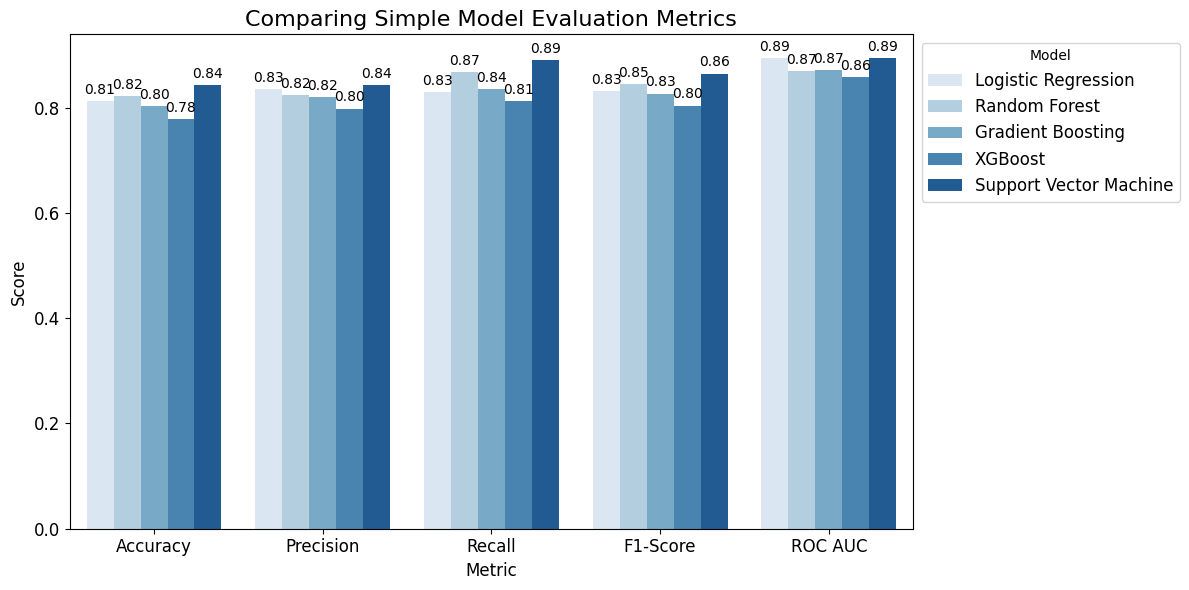

In [15]:
model_eval_df = results_df.rename(columns={'accuracy':'Accuracy', 'precision':'Precision', 'recall':'Recall','f1':'F1-Score','roc_auc':'ROC AUC'})

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
model_eval_df = model_eval_df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6), facecolor='none')
palette = sns.color_palette("Blues", len(model_eval_df['Model'].unique()))
sns.barplot(x='Metric', y='Score', hue='Model', data=model_eval_df, palette=palette)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.title('Comparing Simple Model Evaluation Metrics', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

plt.tight_layout()
plt.savefig('model_evaluation_metrics.png', transparent=True, bbox_inches='tight', facecolor='none')
plt.show()

## **Hyper-tuning Parameters for Logistic Regression Model**

In [16]:
# Hyper-tuning Logistic Regression
warnings.filterwarnings("ignore")

LR_solvers = {
    'Logistic Regression - lbfgs': LogisticRegression(solver = 'lbfgs', random_state = RANDOM_SEED, max_iter = 1000),
    'Logistic Regression - liblinear': LogisticRegression(solver = 'liblinear', random_state = RANDOM_SEED, max_iter = 1000),
    'Logistic Regression - newton-cg': LogisticRegression(solver = 'newton-cg', random_state = RANDOM_SEED, max_iter = 1000),
    'Logistic Regression - newton-cholesky': LogisticRegression(solver = 'newton-cholesky', random_state = RANDOM_SEED, max_iter = 1000),
    'Logistic Regression - sag': LogisticRegression(solver = 'sag', random_state = RANDOM_SEED, max_iter = 1000),
    'Logistic Regression - saga': LogisticRegression(solver = 'saga', random_state = RANDOM_SEED,  max_iter = 1000)
}

LR_results = []

for name, clf in LR_solvers.items():
  LR_results = {'Model': name}
  for metric in score_metrics:
    LR_results[metric] = cross_validation(clf, metric)
  results.append(LR_results)

In [17]:
# Evaluation metrics table for all models
LR_results_df = pd.DataFrame(results)

# Sort by highest accuracy
LR_results_df.sort_values(by = 'accuracy', ascending = False)

,Model,accuracy,precision,recall,f1,roc_auc
4,Support Vector Machine,0.843077,0.842518,0.890240,0.864710,0.894549
1,Random Forest,0.821538,0.824327,0.868018,0.845324,0.869705
0,Logistic Regression,0.812308,0.834586,0.829429,0.831597,0.893410
5,Logistic Regression - lbfgs,0.812308,0.834586,0.829429,0.831597,0.893410
6,Logistic Regression - liblinear,0.812308,0.834586,0.829429,0.831597,0.892257
7,Logistic Regression - newton-cg,0.812308,0.834586,0.829429,0.831597,0.893410
8,Logistic Regression - newton-cholesky,0.812308,0.834586,0.829429,0.831597,0.893410
9,Logistic Regression - sag,0.812308,0.834586,0.829429,0.831597,0.893410
10,Logistic Regression - saga,0.812308,0.834586,0.829429,0.831597,0.893412
2,Gradient Boosting,0.803077,0.820074,0.835135,0.826740,0.870706


In [18]:
warnings.filterwarnings("ignore")

param_grid = {'penalty': [None, 'l2'],
              'C': [0.0001, 0.001, 0.1, 1, 10, 100],
              'class_weight': ['balanced', None]
              }

LR = LogisticRegression(solver = 'lbfgs', random_state = RANDOM_SEED)
grid_search_lr = GridSearchCV(LR, param_grid, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED), scoring = 'accuracy')

grid_search_lr.fit(X_train, y_train)

final_LR = pd.DataFrame(grid_search_lr.cv_results_)
cols = ['param_penalty', 'param_C', 'param_class_weight', 'mean_test_score']
final_LR[cols].sort_values('mean_test_score', ascending = False)

,param_penalty,param_C,param_class_weight,mean_test_score
9,l2,0.1,balanced,0.824615
11,l2,0.1,None,0.821538
17,l2,10,balanced,0.818462
13,l2,1,balanced,0.815385
0,None,0.0001,balanced,0.812308
22,None,100,None,0.812308
21,l2,100,balanced,0.812308
20,None,100,balanced,0.812308
19,l2,10,None,0.812308
18,None,10,None,0.812308


In [19]:
print("Best Parameters:", grid_search_lr.best_params_)
print("Accuracy:", grid_search_lr.best_score_)

Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Accuracy: 0.8246153846153847


In [20]:
best_lr = grid_search_lr.best_estimator_
best_lr.fit(X_train, y_train)
y_pred_best_lr = best_lr.predict(X_test)

# Evaluation scores
accuracy_best_lr = accuracy_score(y_test, y_pred_best_lr)
precision_best_lr = precision_score(y_test, y_pred_best_lr)
recall_best_lr = recall_score(y_test, y_pred_best_lr)
f1_best_lr = f1_score(y_test, y_pred_best_lr)
roc_auc_best_lr = roc_auc_score(y_test, y_pred_best_lr)

# Print evaluation scores
print('Best Logistic Regression Model Accuracy:', accuracy_best_lr)
print('Best Logistic Regression Model Precision:', precision_best_lr)
print('Best Logistic Regression Model Recall:', recall_best_lr)
print('Best Logistic Regression Model F1-Score:', f1_best_lr)
print('Best Logistic Regression Model ROC AUC:', roc_auc_best_lr)


Best Logistic Regression Model Accuracy: 0.8414634146341463
Best Logistic Regression Model Precision: 0.8837209302325582
Best Logistic Regression Model Recall: 0.8260869565217391
Best Logistic Regression Model F1-Score: 0.853932584269663
Best Logistic Regression Model ROC AUC: 0.8435990338164252


##**Hyper-tuning Parameters for Random Forest Model**

In [21]:
warnings.filterwarnings("ignore")

random_grid = {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
                  'max_features': ['auto', 'sqrt'],
                  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                  'min_samples_split': [1, 5, 10],
                  'min_samples_leaf': [1, 2, 3],
                  'bootstrap': [True, False]}

clf_rf = RandomForestClassifier(random_state = RANDOM_SEED)
random_search_rf = RandomizedSearchCV(estimator = clf_rf, param_distributions = random_grid, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED), n_jobs = -1, verbose = 2, random_state=RANDOM_SEED)
random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1738, shuffle=True),
                   estimator=RandomForestClassifier(random_state=1738),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [1, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1738, verbose=2)

In [22]:
print('Best Parameters:', random_search_rf.best_params_)
print('Accuracy:', random_search_rf.best_score_)

Best Parameters: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}
Accuracy: 0.8338461538461539


In [23]:
ran_rf = random_search_rf.best_estimator_
ran_rf.fit(X_train, y_train)
y_pred_ran_rf = ran_rf.predict(X_test)

# Evaluation scores
accuracy_ran_rf = accuracy_score(y_test, y_pred_ran_rf)
precision_ran_rf = precision_score(y_test, y_pred_ran_rf)
recall_ran_rf = recall_score(y_test, y_pred_ran_rf)
f1_ran_rf = f1_score(y_test, y_pred_ran_rf)
roc_auc_ran_rf = roc_auc_score(y_test, y_pred_ran_rf)

# Print evaluation scores
print('Best Random Forest Model Accuracy:', accuracy_ran_rf)
print('Best Random Forest Model Precision:', precision_ran_rf)
print('Best Random Forest Model Recall:', recall_ran_rf)
print('Best Random Forest Model F1-Score:', f1_ran_rf)
print('Best Random Forest Model ROC AUC:', roc_auc_ran_rf)

Best Random Forest Model Accuracy: 0.8048780487804879
Best Random Forest Model Precision: 0.8125
Best Random Forest Model Recall: 0.8478260869565217
Best Random Forest Model F1-Score: 0.8297872340425533
Best Random Forest Model ROC AUC: 0.7989130434782609


##**Hyper-tuning Parameters for SVM**

In [24]:
param_grid = {
  'C': [0.01, 0.1, 1, 10, 100],
  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
  'gamma': ['scale', 'auto']
}

clf_svm = SVC(random_state = RANDOM_SEED)
grid_search_svm = GridSearchCV(clf_svm, param_grid, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED), scoring = 'accuracy')
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1738, shuffle=True),
             estimator=SVC(random_state=1738),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [25]:
final_SVM = pd.DataFrame(grid_search_svm.cv_results_)
cols = ['params', 'mean_test_score']
final_SVM[cols].sort_values('mean_test_score', ascending = False)

,params,mean_test_score
22,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.846154
18,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.843077
0,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}",0.830769
4,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'linear'}",0.830769
19,"{'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}",0.830769
8,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.830769
12,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}",0.830769
9,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.830769
23,"{'C': 1, 'gamma': 'auto', 'kernel': 'sigmoid'}",0.827692
10,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.827692


In [26]:
print('Best Parameters:', grid_search_svm.best_params_)
print('Accuracy:', grid_search_svm.best_score_)

Best Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.8461538461538461


In [27]:
svm = grid_search_svm.best_estimator_
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Evaluation scores
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)

# Print evaluation scores
print('Best SVM Accuracy:', accuracy_svm)
print('Best SVM Precision:', precision_svm)
print('Best SVM Recall:', recall_svm)
print('Best SVM F1-Score:', f1_svm)
print('Best SVM ROC AUC:', roc_auc_svm)

Best SVM Accuracy: 0.7926829268292683
Best SVM Precision: 0.7959183673469388
Best SVM Recall: 0.8478260869565217
Best SVM F1-Score: 0.8210526315789473
Best SVM ROC AUC: 0.7850241545893719


# Visualize Final Results

#### Feature Importance

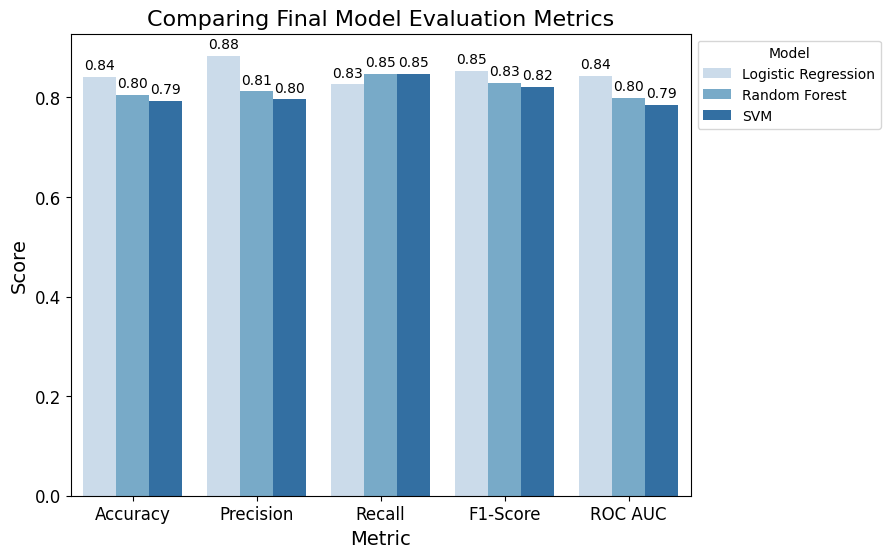

In [28]:
final_results_data = {
  'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
  'Accuracy': [accuracy_best_lr, accuracy_ran_rf, accuracy_svm],
  'Precision': [precision_best_lr, precision_ran_rf, precision_svm],
  'Recall': [recall_best_lr, recall_ran_rf, recall_svm],
  'F1-Score': [f1_best_lr, f1_ran_rf, f1_svm],
  'ROC AUC': [roc_auc_best_lr, roc_auc_ran_rf, roc_auc_svm]
}

# Visualize data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
model_eval_df = pd.DataFrame(final_results_data).melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=model_eval_df, palette="Blues")
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', label_type='edge', padding=3)
plt.title('Comparing Final Model Evaluation Metrics',fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', loc='best', bbox_to_anchor=(1, 1))
plt.show()

In [29]:
# Show feature importance for Logisitic Regression
coefs_lr = best_lr.coef_[0]
features_lr = X_train.columns

feature_importance_lr = pd.DataFrame({
    'Feature': features_lr,
    'Coefficient': coefs_lr,
    'abs_coef': np.abs(coefs_lr)
}).sort_values(by='abs_coef', ascending=False).reset_index().drop('index',axis=1)

feature_importance_lr['Feature'] = feature_importance_lr['Feature'].replace({

    # Top 10 Features
    'oldpeak':'Oldpeak',
    'met':'MET',
    'sex':'Male',
    'cp_angina_atyp': 'Atypical Angina',
    'cp_asymptomatic': 'Asymptomatic Angina',
    'painexer': 'Chest Pain on Exertion',
    'exang': 'Exercise Induced Angina',
    'fbs': 'Fasting Blood Sugar >120 mg/dl',
    'pro': 'CCB for Exercise ECG',
    'relrest': 'Chest Pain Relieved After Rest',

    # Bottom 10 Features
    'restecg_normal':'Normal Resting ECG',
    'trestbps':'Resting Blood Pressure',
    'restecg_lvh':'Rest ECG Probable/Definite LVH',
    'painloc':'Substernal Chest Pain',
    'trestbpd':'Resting Blood Pressure',
    'restecg_stt_wave':'Rest ECG ST-T Wave Abnormality',
    'chol':'Serum Cholesterol',
    'diuretic':'Diuretic for Exercise ECG',
    'tpeakbps':'Peak Exercise Blood Pressure',
    'age':'Age'
})

most_important_features = feature_importance_lr.iloc[-10:]
least_important_features = feature_importance_lr.iloc[-10:]

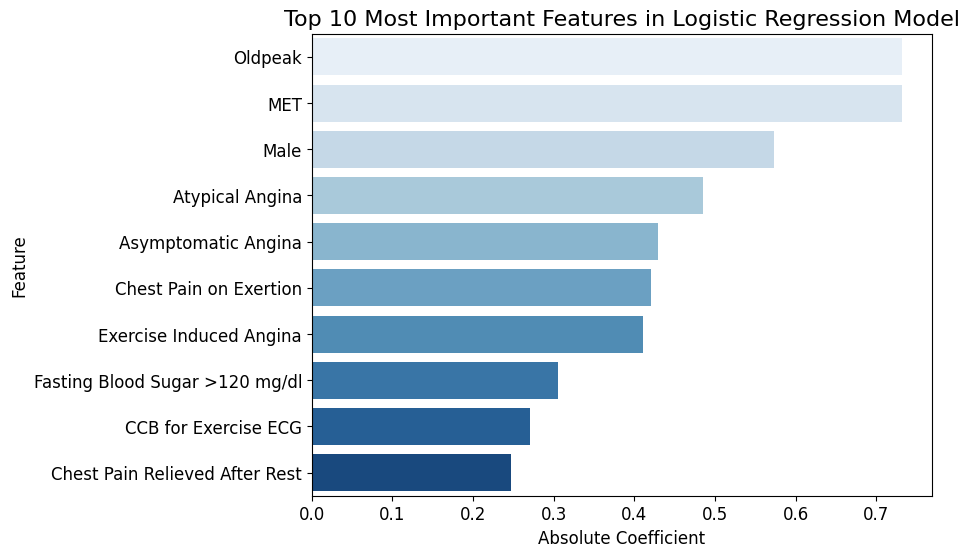

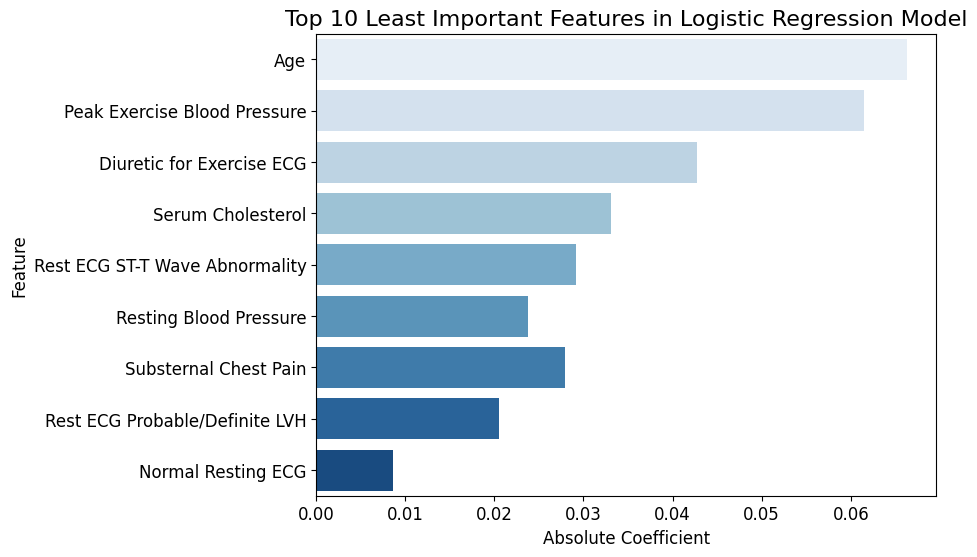

In [30]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(8, 6))
sns.barplot(x='abs_coef', y='Feature', data=feature_importance_lr.iloc[:10], palette="Blues", errorbar=None)
plt.title('Top 10 Most Important Features in Logistic Regression Model', fontsize=16)
plt.xlabel('Absolute Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='abs_coef', y='Feature', data=feature_importance_lr.iloc[-10:], palette="Blues", errorbar=None)
plt.title('Top 10 Least Important Features in Logistic Regression Model', fontsize=16)
plt.xlabel('Absolute Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


#### Confusion Matrix



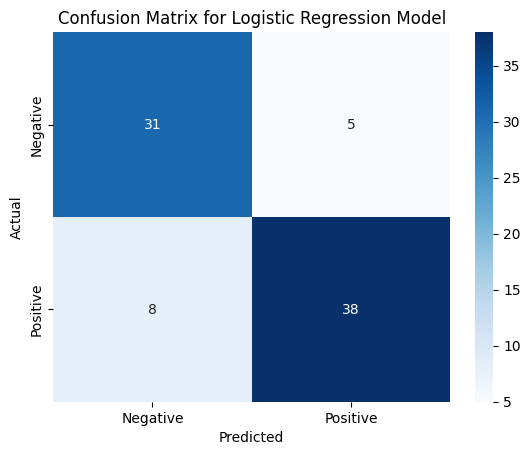

In [32]:
cm = confusion_matrix(y_test, y_pred_best_lr)
sns.heatmap(cm,
            annot=True,
            cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()